In [1]:
#!/usr/bin/env python3
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf

from src.architecture import FootpathModelArchitecture
from src.miscellaneous import load_random_image, preprocess_image, save_predicted_mask
from src.visualization import create_overlay, display_images

## Load and prepare parameters 

In [24]:
parameter_directory = './parameters/'
testing_parameter_file = 'comparing.json'
parameter_path = parameter_directory + testing_parameter_file

In [25]:
with open(parameter_path) as parameter_file:
    test_parameters = json.load(parameter_file)

In [26]:
model_parameters = test_parameters['models']
test_data_parameters = test_parameters['test_data']
test_output_parameters = test_parameters['test_output']

## Build the model structure - Kitti example

In [7]:
kitti_image_parameters = test_data_parameters['kitti']['image_dimensions']
kitti_input_width = kitti_image_parameters['width']
kitti_input_height = kitti_image_parameters['height']
kitti_image_dimensions = (kitti_input_width, kitti_input_height)
kitti_input_shape = (kitti_input_width, kitti_input_height, 3)

In [8]:
kitti_footpath_model = FootpathModelArchitecture(kitti_input_shape).footpath_model

## Load weights

In [9]:
model_directory = model_parameters['kitti-120e']['root_directory']

### - from .h5 file

In [10]:
model_file = model_parameters['kitti-120e']['model_file_name']

In [11]:
kitti_footpath_model.load_weights(model_directory + model_file)

### - from checkpoint

In [103]:
checkpoint_folder = model_parameters['kitti-120e']['checkpoint_folder']
checkpoint_filename = model_parameters['kitti-120e']['checkpoint_filename']
kitti_footpath_model.load_weights(model_directory + checkpoint_folder + checkpoint_filename)

## Visualize predictions of the model

In [12]:
kitti_test_data_directory = test_data_parameters['kitti']['test_data_directory']

In [13]:
kitti_test_image_names = os.listdir(kitti_test_data_directory)

In [14]:
number_of_examples = 5

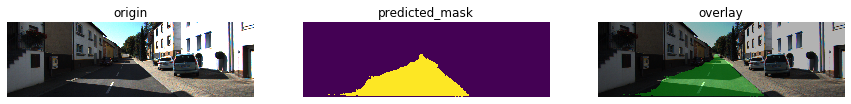

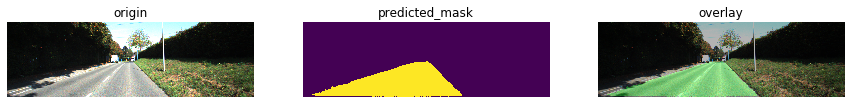

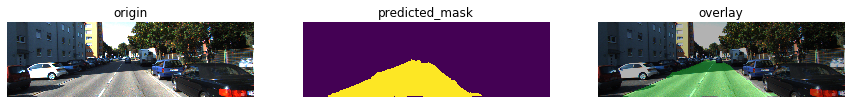

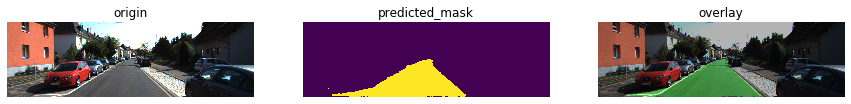

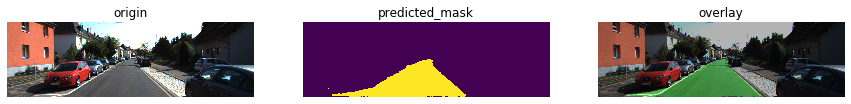

In [15]:
for i in range(number_of_examples):
    test_image = load_random_image(kitti_test_data_directory, image_dimension=kitti_image_dimensions)
    preprocessed_image = preprocess_image(test_image, expand_dimension=True)
    predicted_mask = kitti_footpath_model.predict(preprocessed_image)
    predicted_mask = predicted_mask > 0.5
    overlay = create_overlay(test_image, predicted_mask, alpha=0.3, from_prediction=True)
    display_images([test_image, predicted_mask, overlay], ['origin', 'predicted_mask', 'overlay'])

## Compare models against each other

### Prepare the data and the models that shall be considered

In [27]:
test_data_paths = []
image_shapes = []
model_paths = []

In [28]:
# Add Kitti based model and Kitti test directory
test_data_paths.append(test_data_parameters['kitti']['test_data_directory'])
image_shapes.append((test_data_parameters['kitti']['image_dimensions']['width'],
                     test_data_parameters['kitti']['image_dimensions']['height'], 3))
model_paths.append(model_parameters['kitti-120e']['root_directory'] +
                   model_parameters['kitti-120e']['model_file_name'])

In [29]:
# Add DeepScene based model and DeepScene test data
test_data_paths.append(test_data_parameters['ds']['test_data_directory'])
image_shapes.append((test_data_parameters['ds']['image_dimensions']['width'],
                     test_data_parameters['ds']['image_dimensions']['height'], 3))
model_paths.append(model_parameters['ds-120e']['root_directory'] +
                   model_parameters['ds-120e']['model_file_name'])

In [30]:
# Add model based on a Kitti-DeepScene mix and the Landsberg am Lech dataset
test_data_paths.append(test_data_parameters['lal']['test_data_directory'])
image_shapes.append((test_data_parameters['lal']['image_dimensions']['width'],
                     test_data_parameters['lal']['image_dimensions']['height'], 3))
model_paths.append(model_parameters['kitti-120e-ds-35']['root_directory'] +
                   model_parameters['kitti-120e-ds-35']['model_file_name'])

In [31]:
original_images = []
predictions = []
for i in range(len(model_paths)):
    predictions.append([])

### Create a directory in which the predictions will be saved

The reasons why the outputs need to be saved in a directory are the amounts of memory that are needed for the act of loading saving the outputs in memory.

In [32]:
# Create test output directory and the original_images subfolder
origin_test_output_directory = test_output_parameters['test_output_directory']

try:
    os.mkdir(origin_test_output_directory)
    test_output_directory = origin_test_output_directory
    if (test_output_directory[-1] == '/'):
        os.mkdir(test_output_directory + 'original_images/')
    else:
        test_output_directory = test_output_directory + '/'
        os.mkdir(test_output_directory + 'original_images/')
except:
    if (origin_test_output_directory[-1] == '/'):
        origin_test_output_directory = origin_test_output_directory[:-1]
    counter = 1
    while (True):
        new_test_output_directory = origin_test_output_directory + '-' + str(counter)
        if (os.path.exists(new_test_output_directory)):
            counter += 1
            continue
        else:
            new_test_output_directory = new_test_output_directory + '/'
            os.mkdir(new_test_output_directory)
            test_output_directory = new_test_output_directory
            os.mkdir(test_output_directory + 'original_images/')
            break

### Predict the specified test data with all aforementioned models

The outputs are saved as overlays in model specfic folders. 

In [33]:
# Load n number of pictures from each training data (not random)
number_of_images_per_set = 4

# Iterate over the provided models and datasets and save the overlays to the test_output_directory
for model_index, model in enumerate(model_paths):
    try:
        os.mkdir(test_output_directory + str(model_index))
    except:
        pass
    for dataset_index, test_data in enumerate(test_data_paths):
        footpath_model = FootpathModelArchitecture(image_shapes[dataset_index]).footpath_model
        footpath_model.load_weights(model)
        image_names = os.listdir(test_data)

        for i in range(number_of_images_per_set):
            test_image_path = test_data + image_names[i]
            test_image = tf.keras.preprocessing.image.load_img(test_image_path,
                                                               target_size=(image_shapes[dataset_index][0],
                                                                            image_shapes[dataset_index][1]))
            
            test_image.save(test_output_directory + 'original_images/' + str(dataset_index) + '-' + 
                            str(i) + '.png', 'PNG')
            
            preprocessed_test_image = preprocess_image(test_image, expand_dimension=True)

            prediction = footpath_model.predict(preprocessed_test_image)
            overlay = create_overlay(test_image, prediction, alpha=0.3, from_prediction=True)
            
            overlay.save(test_output_directory + str(model_index) + '/' + str(dataset_index) + '-' + 
                         str(i) + '.png')

### Visualize the results

kitti


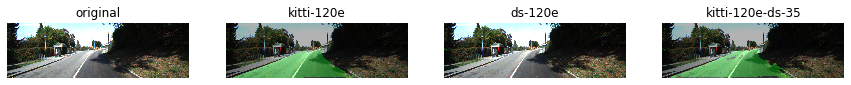

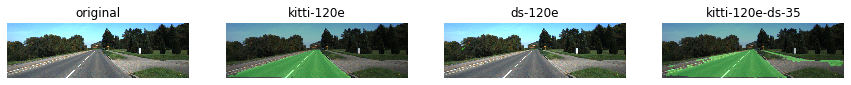

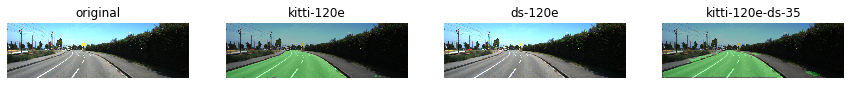

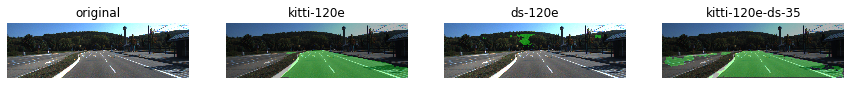

ds


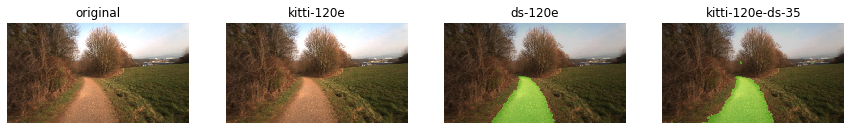

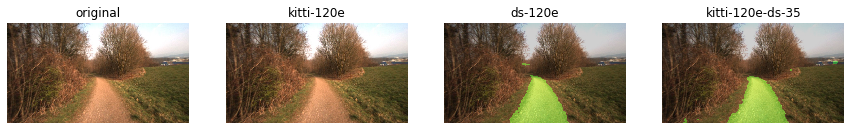

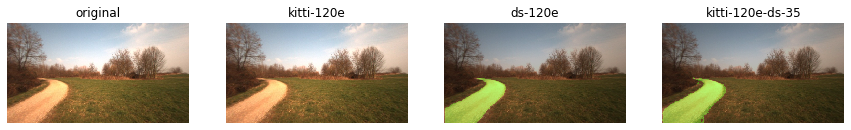

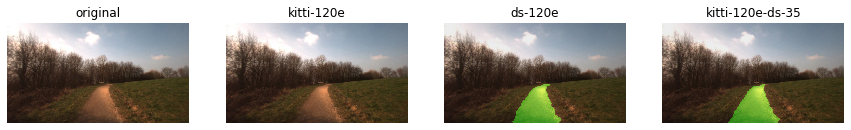

lal


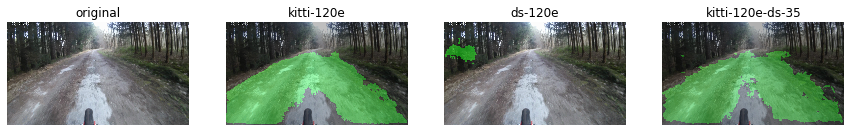

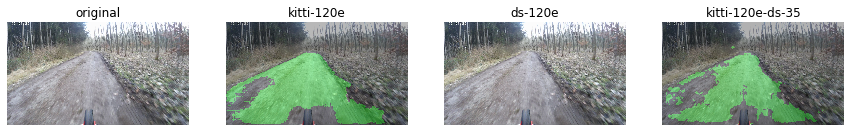

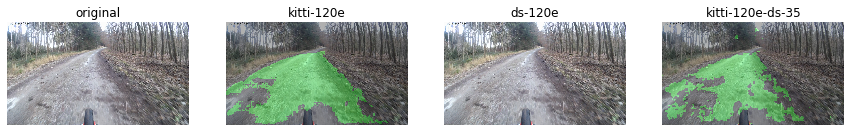

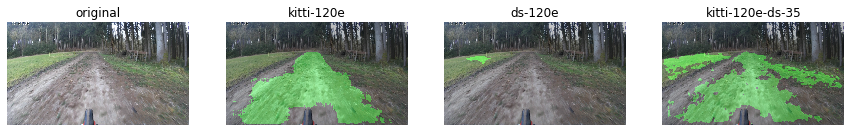

In [75]:
# Number of images in each model output folder
number_of_images_per_model = number_of_images_per_set * len(test_data_paths)

number_of_rows_in_plot = number_of_images_per_model
number_of_columns_in_plot = len(model_paths) + 1

original_image_names = os.listdir(test_output_directory + 'original_images/')
original_image_names.sort()

dataset_in_focus = list(test_data_parameters.keys())
dataset_counter = 0

labels = list(model_parameters.keys())
labels.insert(0, 'original')

for image_counter, image_name in enumerate(original_image_names):
    if (image_counter % number_of_images_per_set == 0):
        print(dataset_in_focus[dataset_counter])
        dataset_counter += 1
    
    images_to_compare = []
    images_to_compare.append(tf.keras.preprocessing.image.load_img(test_output_directory + 'original_images/' +
                                                                   image_name))
    for model_index in range(len(model_paths)):
        images_to_compare.append(tf.keras.preprocessing.image.load_img(test_output_directory + str(model_index) +
                                                                       '/' + image_name))
    display_images(images_to_compare, labels)